/Users/pianistprogrammer/anaconda3/lib/python3.7/site-packages/scipy/sparse/lil.py:512: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warning.
  if not i.flags.writeable or i.dtype not in (np.int32, np.int64):
/Users/pianistprogrammer/anaconda3/lib/python3.7/site-packages/scipy/sparse/lil.py:514: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warning.
  if not j.flags.writeable or j.dtype not in (np.int32, np.int64):
/Users/pianistprogrammer/anaconda3/lib/python3.7/site-packages/scipy/sparse/lil.py:518: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warning.
  if not x.flags.writeable:


 [[0.07984149 0.03914155 0.05658015 ... 0.         0.         0.        ]
 [0.07310947 0.07121469 0.10228164 ... 0.         0.         0.        ]
 [0.09262447 0.08783106 0.12289134 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.16428271 0.17173768 0.17379338]
 [0.         0.         0.         ... 0.15968731 0.16562451 0.16805796]
 [0.65398648 0.63834916 0.64790381 ... 0.1653118  0.16187044 0.15556285]]


[[1.         0.87545119 0.65408731 ... 0.52092121 0.70431281 0.79001277]
 [0.87545119 1.         0.91148996 ... 0.7257501  0.82025823 0.75104373]
 [0.65408731 0.91148996 1.         ... 0.78459335 0.81339756 0.62941686]
 ...
 [0.52092121 0.7257501  0.78459335 ... 1.         0.90017203 0.49972442]
 [0.70431281 0.82025823 0.81339756 ... 0.90017203 1.         0.77786795]
 [0.79001277 0.75104373 0.62941686 ... 0.49972442 0.77786795 1.        ]]


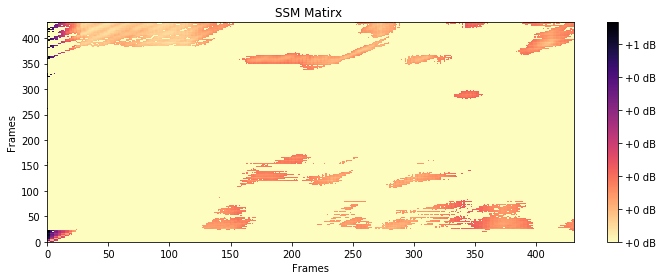

In [27]:
# import modules
import librosa
import librosa.display
import IPython.display as ipd
import matplotlib.pyplot as plt
from scipy import signal
from scipy import stats
from scipy.io import wavfile
import numpy as np
import math
from sklearn.metrics import pairwise_distances


# to get the similarity matrix between two frames of the same signal
# read audio file
y, sr = librosa.load('Data/genres_original/classical/classical.00011.wav', duration=10)
#y, sr = librosa.load('mazing.wav', duration=30.0)

# print(f"Sample rate -> {sr}")
# print(f"Sample size -> {y.size}")

y_comp, sr = librosa.load('Data/genres_original/classical/classical.00011.wav',offset=10, duration=10) #load signal after 10s
# print(f"Sample comparison size -> {y_comp.size}")

hop_length = 512
frame_length = 1024
 
chroma_ref = librosa.feature.chroma_cqt(y=y, sr=sr, hop_length=hop_length)
chroma_comp = librosa.feature.chroma_cqt(y=y_comp, sr=sr, hop_length=hop_length)

# Use time-delay embedding to get a cleaner recurrence matrix
x_ref = librosa.feature.stack_memory(chroma_ref, n_steps=10, delay=3)
x_comp = librosa.feature.stack_memory(chroma_comp, n_steps=10, delay=3)

# mfcc_ref = librosa.feature.mfcc(y=y, sr=sr, hop_length=hop_length)
# mfcc_comp = librosa.feature.mfcc(y=y_comp, sr=sr, hop_length=hop_length)


#print(f"chroma reference -> {x_ref}")
#print(f"chroma comparison reference -> {x_comp}")

xsim = librosa.segment.cross_similarity(x_comp, x_ref, metric='cosine', mode='distance')

print(' {}\n\n'.format(xsim))

cross_sm =  1-pairwise_distances(x_ref, metric="cosine")
print(cross_sm)

# alltruesarray = np.count_nonzero(xsim.astype(int), axis=1)
# alltrues = np.count_nonzero(xsim.astype(int))
# allfalse = xsim.size - np.count_nonzero(xsim.astype(int))

# print(alltruesarray, stats.mode(alltruesarray))
# print(alltrues)
# print(allfalse)

# xsim_aff = librosa.segment.cross_similarity(x_comp, x_ref, metric='cosine', mode='distance')

plt.figure(figsize=(10,4))
librosa.display.specshow(xsim, sr=sr, x_axis='frames', y_axis='frames', cmap='magma_r')
plt.title('SSM Matirx ')

# draw a color bar
plt.colorbar(format='%+02.0f dB')

# Make the figure layout compact
plt.tight_layout()

In [2]:
onset_env = librosa.onset.onset_strength(y, sr=sr, aggregate=np.median)
# get tempo and beats
tempo, beats = librosa.beat.beat_track(onset_envelope=onset_env, sr=sr)
# we assume 3/4 time
meter = 4
# calculate number of full measures 
measures = (len(beats) // meter)
print(f"measures -> {beats[:measures]}")
print(f"tempo -> {tempo}")
print(f"beats -> {beats}")


# get onset strengths for the known beat positions
# Note: this is somewhat naive, as the main strength may be *around*
#       rather than *on* the detected beat position. 
beat_strengths = onset_env[beats]
# make sure we only consider full measures
# and convert to 2d array with indices for measure and beatpos
measure_beat_strengths = beat_strengths[:measures * meter].reshape(-1, meter)
# add up strengths per beat position
beat_pos_strength = np.sum(measure_beat_strengths, axis=0)
# find the beat position with max strength
downbeat_pos = np.argmax(beat_pos_strength)
# convert the beat positions to the same 2d measure format
full_measure_beats = beats[:measures * meter].reshape(-1, meter)
# and select the beat position we want: downbeat_pos
downbeat_frames = full_measure_beats[:, downbeat_pos]
print('Downbeat frames: {}'.format(downbeat_frames))
# print times
downbeat_times = librosa.frames_to_time(downbeat_frames, sr=sr)
print('Downbeat times in s: {}\n'.format(downbeat_times))

tempo, beat_times = librosa.beat.beat_track(y, sr=sr, units='time')
print('beat times: {}\n'.format(beat_times))

measures -> [138 155 174 192 209 225 242 259 276 292 309 326 344 361]
tempo -> 151.99908088235293
beats -> [ 138  155  174  192  209  225  242  259  276  292  309  326  344  361
  380  399  416  432  448  465  482  498  515  532  550  568  586  604
  621  638  654  670  687  704  720  736  754  773  790  806  823  840
  857  874  891  908  924  940  956  975  992 1009 1025 1042 1058 1075
 1092]
Downbeat frames: [ 155  225  292  361  432  498  568  638  704  773  840  908  975 1042]
Downbeat times in s: [ 3.59909297  5.2244898   6.78022676  8.38240363 10.03102041 11.56353741
 13.18893424 14.81433107 16.34684807 17.94902494 19.5047619  21.08371882
 22.63945578 24.19519274]

beat times: [ 3.20435374  3.59909297  4.04027211  4.45823129  4.85297052  5.2244898
  5.61922902  6.01396825  6.40870748  6.78022676  7.17496599  7.56970522
  7.9876644   8.38240363  8.82358277  9.2647619   9.65950113 10.03102041
 10.40253968 10.79727891 11.19201814 11.56353741 11.95827664 12.35301587
 12.77097506 13.

NameError: name 'xsim_aff' is not defined

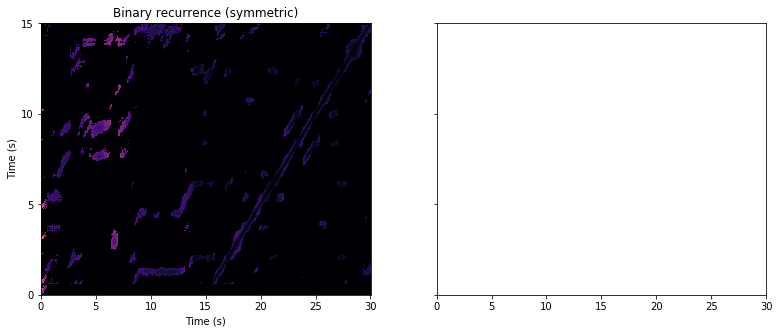

In [3]:
fig, ax = plt.subplots(ncols=2, figsize=(13,5), sharex=True, sharey=True)
imgsim = librosa.display.specshow(xsim, x_axis='s', y_axis='s',
                         hop_length=hop_length, ax=ax[0])
ax[0].set(title='Binary recurrence (symmetric)')
imgaff = librosa.display.specshow(xsim_aff, x_axis='s', y_axis='s',
                         cmap='magma_r', hop_length=hop_length, ax=ax[1])
ax[1].set(title='Affinity recurrence')
ax[1].label_outer()

In [ ]:
# find the number of onset notes detectable
onsets = librosa.onset.onset_detect(y=y, sr=sr, units='time')

In [ ]:
temporal = librosa.feature.mfcc(y=y, sr=sr, hop_length=hop_length)
#chroma_stack = librosa.feature.stack_memory(chroma, n_steps=10, delay=3)
R = librosa.segment.recurrence_matrix(onsets)

In [ ]:
fig, ax = plt.subplots(ncols=1, nrows=2, figsize=(10,10), sharex=True, sharey=True)
imgsim = librosa.display.specshow(R, x_axis='s', y_axis='s',
                         hop_length=hop_length, ax=ax[0])
ax[0].set(title='Binary recurrence (symmetric)')

In [ ]:
oenv = librosa.onset.onset_strength(y=y, sr=sr, hop_length=hop_length)
tempogram = librosa.feature.tempogram(onset_envelope=oenv, sr=sr,hop_length=hop_length)
# Compute global onset autocorrelation
ac_global = librosa.autocorrelate(oenv, max_size=tempogram.shape[0])
ac_global = librosa.util.normalize(ac_global)
# Estimate the global tempo for display purposes
tempo = librosa.beat.tempo(onset_envelope=oenv, sr=sr,hop_length=hop_length)[0]
print(tempo)

In [ ]:
frequencies, times, spectrogram = signal.spectrogram(y, sr)
ipd.Audio(y, rate=sr)

In [ ]:
fig, ax = plt.subplots(nrows=2, figsize=(10, 10))
times = librosa.times_like(oenv, sr=sr, hop_length=hop_length)
ax[0].plot(times, oenv, label='Onset strength')
ax[0].label_outer()
ax[0].legend(frameon=True)
librosa.display.specshow(tempogram, sr=sr, hop_length=hop_length,
                         x_axis='time', y_axis='tempo', cmap='magma',
                         ax=ax[1])
ax[1].axhline(tempo, color='w', linestyle='--', alpha=1,
            label='Estimated tempo={:g}'.format(tempo))
ax[1].legend(loc='upper right')
ax[1].set(title='Tempogram')

In [ ]:
plt.figure(figsize=(14, 5))
#plotting the sampled signal
librosa.display.waveplot(y, sr=44100)

In [ ]:
# approach 1 - onset detection and dynamic programming
tempo, beat_times = librosa.beat.beat_track(y, sr=sr, units='time')
duration = librosa.get_duration(y=y, sr=sr)
#tempo, beats = librosa.beat.beat_track(y, sr=sr)
beat_times = librosa.frames_to_time(beats, sr=sr)
clicks = librosa.clicks(beat_times, sr=sr, length=len(y))
#print(beat_times, beat_times.size)
#print(tempo, duration)
print(f"Time signature -> {(round(tempo/beat_times.size)) * (math.floor(beat_times.size /duration))}")

#beat_times
ipd.Audio(y + clicks, rate=sr)

In [ ]:
def strip(x, frame_length, hop_length):

    # Compute RMSE.
    rmse = librosa.feature.rms(beat_times, frame_length=frame_length, hop_length=hop_length, center=True)
    print(rmse.shape)
    # Identify the first frame index where RMSE exceeds a threshold.
    thresh = 0.01
    frame_index = 0
    while rmse[0][frame_index] < thresh:
        frame_index += 1
        
    # Convert units of frames to samples.
    start_sample_index = librosa.frames_to_samples(frame_index, hop_length=hop_length)
    
    # Return the trimmed signal.
    return x[start_sample_index:]

In [ ]:
sig = strip(beat_times, frame_length, hop_length)
print(sig, sig.size)

In [ ]:
def draw_plot(is_draw_plots: bool, yData, title, xAxis="Time", yAxis="Amplituda", xData=0):
    if is_draw_plots:
        if xData is 0:
            plt.plot(yData)
        else:
            plt.plot(yData, xData)
        plt.title(title)
        plt.xlabel(xAxis)
        plt.ylabel(yAxis)
        plt.show()

In [ ]:
def __four_forth(tempo: int, sr: int):
        fil = np.zeros(int(4 * sr * (60 / tempo)))
        nstep = np.floor(60 / tempo * sr)

        value = 1
        fil[int(1 * nstep)] = 1 * value
        fil[int(3 * nstep)] = 1 * value
        
        draw_plot('false', fil, "4\\4 Meter", "Sample/Time", "Amplitude")
        print(fil)
        return "4\\4", fil

In [ ]:
__four_forth(tempo, sr)

In [28]:
!pip install --upgrade pip

    100% |████████████████████████████████| 1.6MB 12.1MB/s 
  Found existing installation: pip 18.1
    Uninstalling pip-18.1:
      Successfully uninstalled pip-18.1
